In [98]:
# EDA

PATH = 'Data/'

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from datetime import datetime, date

# EDA

In [414]:
df = pd.read_csv(PATH + 'FINAL_USO.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Date'], inplace=True)

for i in df.columns:
    if ("Trend" in i):
        df.drop([i],axis=1,inplace=True)

df.replace(0, np.NaN, inplace=True)
df.fillna(method="ffill", inplace=True)
df.shape

C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\4112089339.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


(1718, 73)

In [415]:
df.rename(columns={'Open': 'GLD_open', 'High': 'GLD_high', 'Low': 'GLD_low', 'Close': 'GLD_close', 'Adj Close': 'GLD_Ajclose', 'Volume': 'GLD_volume'}, inplace=True)

df.columns = ['Date'] + ['_'.join([i.split('_')[0], i.split('_')[1].lower()]).replace("price", "close").replace("adj close", "ajclose") for i in df.columns[1:]]
df.columns

Index(['Date', 'GLD_open', 'GLD_high', 'GLD_low', 'GLD_close', 'GLD_ajclose',
       'GLD_volume', 'SP_open', 'SP_high', 'SP_low', 'SP_close', 'SP_ajclose',
       'SP_volume', 'DJ_open', 'DJ_high', 'DJ_low', 'DJ_close', 'DJ_ajclose',
       'DJ_volume', 'EG_open', 'EG_high', 'EG_low', 'EG_close', 'EG_ajclose',
       'EG_volume', 'EU_close', 'EU_open', 'EU_high', 'EU_low', 'OF_close',
       'OF_open', 'OF_high', 'OF_low', 'OF_volume', 'OS_close', 'OS_open',
       'OS_high', 'OS_low', 'SF_close', 'SF_open', 'SF_high', 'SF_low',
       'SF_volume', 'USB_close', 'USB_open', 'USB_high', 'USB_low',
       'PLT_close', 'PLT_open', 'PLT_high', 'PLT_low', 'PLD_close', 'PLD_open',
       'PLD_high', 'PLD_low', 'RHO_close', 'USDI_close', 'USDI_open',
       'USDI_high', 'USDI_low', 'USDI_volume', 'GDX_open', 'GDX_high',
       'GDX_low', 'GDX_close', 'GDX_ajclose', 'GDX_volume', 'USO_open',
       'USO_high', 'USO_low', 'USO_close', 'USO_ajclose', 'USO_volume'],
      dtype='object')

## Only close&volume

In [331]:
# simplified_col = ['Date', 'GLD_ajclose', 'GLD_volume', 'SP_ajclose', 'SP_volume', 'DJ_ajclose', 'DJ_volume', 'EG_ajclose', 'EG_volume', 'EU_close', 'OF_close', 'OF_volume', 'OS_close', 'SF_close', 'SF_volume', 'USB_close', 'PLT_close', 'PLD_close', 'RHO_close', 'USDI_close', 'USDI_volume', 'GDX_ajclose', 'GDX_volume', 'USO_ajclose', 'USO_volume']
# df = df[simplified_col]
# df

In [416]:
# log return
for i in df.columns:
    if (i != 'Date'):
        df[i] = np.log(df[i].pct_change() + 1)
# df.dropna(inplace=True)

# 5d vol
for i in df.columns:
    if (i != 'Date'):
        df[f"{i}_vol5"] = df[i].rolling(window=5).std()
df.dropna(inplace=True)

df.head()

C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1569281545.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_vol5"] = df[i].rolling(window=5).std()
C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1569281545.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_vol5"] = df[i].rolling(window=5).std()
C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1569281545.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

,Date,GLD_open,GLD_high,GLD_low,GLD_close,GLD_ajclose,GLD_volume,SP_open,SP_high,SP_low,...,GDX_low_vol5,GDX_close_vol5,GDX_ajclose_vol5,GDX_volume_vol5,USO_open_vol5,USO_high_vol5,USO_low_vol5,USO_close_vol5,USO_ajclose_vol5,USO_volume_vol5
5,2011-12-22,-0.004021,-0.004645,-0.005137,-0.007152,-0.007152,-0.193219,0.005632,0.008328,0.011985,...,0.017971,0.025048,0.025048,0.292712,0.016682,0.016614,0.016387,0.015344,0.015344,0.420295
6,2011-12-23,0.000000,-0.001979,0.003150,0.001729,0.001729,-1.020170,0.008310,0.008180,0.009454,...,0.018232,0.023636,0.023882,0.517693,0.008133,0.013184,0.012972,0.015159,0.015159,0.515217
7,2011-12-27,-0.008156,-0.006025,-0.008249,-0.008997,-0.008997,0.321832,0.003971,0.003080,0.005170,...,0.016481,0.020384,0.020588,0.526274,0.009422,0.011150,0.013580,0.013047,0.013047,0.874611
8,2011-12-28,-0.006664,-0.008328,-0.025427,-0.025366,-0.025366,1.206456,0.002691,-0.002289,-0.010607,...,0.016586,0.016522,0.017365,0.786543,0.005744,0.010302,0.009175,0.013591,0.013591,0.867329
9,2011-12-29,-0.032727,-0.023216,-0.015991,-0.004579,-0.004579,0.186818,-0.010089,-0.002215,0.001042,...,0.015690,0.022457,0.022941,0.774431,0.010816,0.011063,0.010703,0.012278,0.012278,0.904450


In [333]:
# df = df.copy()
# for i in df.columns:
#     if (i != 'Date'):
#         for j in range(1, 11):
#             df[f"{i}_l{j}"] = df[i].shift(j)
# df.dropna(inplace=True)

C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1074884844.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_l{j}"] = df[i].shift(j)
C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1074884844.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_l{j}"] = df[i].shift(j)
C:\Users\yuril\AppData\Local\Temp\ipykernel_15656\1074884844.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [417]:
df = df.copy()
df['SP_ajclose_vol5_t+5'] = df['SP_ajclose_vol5'].shift(-5)
df.dropna(inplace=True)
# df[['SP_ajclose_vol5_t+5', 'SP_ajclose_vol5']]

## add garch to data

In [382]:
df['garch_vol'] = [None] + pred_garch_test
df.dropna(inplace=True)
df

,Date,GLD_open,GLD_high,GLD_low,GLD_close,GLD_ajclose,GLD_volume,SP_open,SP_high,SP_low,...,GDX_ajclose_vol5,GDX_volume_vol5,USO_open_vol5,USO_high_vol5,USO_low_vol5,USO_close_vol5,USO_ajclose_vol5,USO_volume_vol5,SP_ajclose_vol5_t+1,garch_vol
1,2011-12-23,0.000000,-0.001979,0.003150,0.001729,0.001729,-1.020170,0.008310,0.008180,0.009454,...,0.023882,0.517693,0.008133,0.013184,0.012972,0.015159,0.015159,0.515217,0.011672,0.000000
2,2011-12-27,-0.008156,-0.006025,-0.008249,-0.008997,-0.008997,0.321832,0.003971,0.003080,0.005170,...,0.020588,0.526274,0.009422,0.011150,0.013580,0.013047,0.013047,0.874611,0.009020,0.000041
3,2011-12-28,-0.006664,-0.008328,-0.025427,-0.025366,-0.025366,1.206456,0.002691,-0.002289,-0.010607,...,0.017365,0.786543,0.005744,0.010302,0.009175,0.013591,0.013591,0.867329,0.009865,0.003813
4,2011-12-29,-0.032727,-0.023216,-0.015991,-0.004579,-0.004579,0.186818,-0.010089,-0.002215,0.001042,...,0.022941,0.774431,0.010816,0.011063,0.010703,0.012278,0.012278,0.904450,0.009794,0.010533
5,2011-12-30,0.020251,0.019904,0.023463,0.010915,0.010915,-0.601884,0.006209,0.000633,0.005113,...,0.023203,0.754216,0.009266,0.010382,0.006057,0.012777,0.012777,0.920187,0.011617,0.010243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,2018-12-21,0.000671,-0.004101,-0.000927,-0.004370,-0.004370,-0.311715,-0.012566,-0.007620,-0.019273,...,0.038382,0.358393,0.014391,0.012329,0.032012,0.032241,0.032241,0.277609,0.009505,0.013261
1708,2018-12-24,0.003183,0.007436,0.008398,0.010891,0.010891,-0.336387,-0.031704,-0.036167,-0.024081,...,0.039440,0.326108,0.015324,0.011478,0.031578,0.031915,0.031915,0.376180,0.031208,0.014911
1709,2018-12-26,0.008743,0.007133,0.000000,-0.003004,-0.003004,0.383933,-0.012926,0.021930,-0.002179,...,0.039688,0.336321,0.011821,0.028592,0.019613,0.040640,0.040640,0.478797,0.031198,0.017751
1710,2018-12-27,-0.000415,-0.000827,0.004756,0.007576,0.007576,-0.185420,0.027586,0.008534,0.022001,...,0.027145,0.264934,0.024932,0.029439,0.018008,0.040569,0.040569,0.448214,0.030091,0.026405


In [383]:
len(pred_garch_test)

1711

In [385]:
df.columns.tolist()

['Date',
 'GLD_open',
 'GLD_high',
 'GLD_low',
 'GLD_close',
 'GLD_ajclose',
 'GLD_volume',
 'SP_open',
 'SP_high',
 'SP_low',
 'SP_close',
 'SP_ajclose',
 'SP_volume',
 'DJ_open',
 'DJ_high',
 'DJ_low',
 'DJ_close',
 'DJ_ajclose',
 'DJ_volume',
 'EG_open',
 'EG_high',
 'EG_low',
 'EG_close',
 'EG_ajclose',
 'EG_volume',
 'EU_close',
 'EU_open',
 'EU_high',
 'EU_low',
 'OF_close',
 'OF_open',
 'OF_high',
 'OF_low',
 'OF_volume',
 'OS_close',
 'OS_open',
 'OS_high',
 'OS_low',
 'SF_close',
 'SF_open',
 'SF_high',
 'SF_low',
 'SF_volume',
 'USB_close',
 'USB_open',
 'USB_high',
 'USB_low',
 'PLT_close',
 'PLT_open',
 'PLT_high',
 'PLT_low',
 'PLD_close',
 'PLD_open',
 'PLD_high',
 'PLD_low',
 'RHO_close',
 'USDI_close',
 'USDI_open',
 'USDI_high',
 'USDI_low',
 'USDI_volume',
 'GDX_open',
 'GDX_high',
 'GDX_low',
 'GDX_close',
 'GDX_ajclose',
 'GDX_volume',
 'USO_open',
 'USO_high',
 'USO_low',
 'USO_close',
 'USO_ajclose',
 'USO_volume',
 'GLD_open_vol5',
 'GLD_high_vol5',
 'GLD_low_vol

## Dataset in paper

In [ ]:
df_paper = df.copy()
df_paper = df_paper[['Date', 'SP_ajclose', 'SP_ajclose_vol5', 'garch_vol', 'SP_ajclose_vol5_t+1']] #'SP_volume', 



In [ ]:
cutoff_date = "2017-01-03"
df_train = df_paper[df_paper.Date < cutoff_date]
df_test = df_paper[df_paper.Date >= cutoff_date]

X_train = df_train.drop(['Date', 'SP_ajclose_vol5_t+1'], axis=1)
y_train = df_train['SP_ajclose_vol5_t+1']

X_test = df_test.drop(['Date', 'SP_ajclose_vol5_t+1'], axis=1)
y_test = df_test['SP_ajclose_vol5_t+1']

### train test

In [418]:
df.reset_index(inplace=True, drop=True)
df.loc[(df['Date'] == "2017-01-03")]         # .isna().sum()


,Date,GLD_open,GLD_high,GLD_low,GLD_close,GLD_ajclose,GLD_volume,SP_open,SP_high,SP_low,...,GDX_close_vol5,GDX_ajclose_vol5,GDX_volume_vol5,USO_open_vol5,USO_high_vol5,USO_low_vol5,USO_close_vol5,USO_ajclose_vol5,USO_volume_vol5,SP_ajclose_vol5_t+5
1217,2017-01-03,-0.006909,0.003429,-0.001462,0.007815,0.007815,-0.164542,0.001378,0.004438,0.00515,...,0.040411,0.040411,0.445707,0.014168,0.013498,0.015769,0.014013,0.014013,0.401134,0.003663


In [419]:
cutoff_date = "2017-01-03"
df_train = df[df.Date < cutoff_date]
df_test = df[df.Date >= cutoff_date]

X_train = df_train.drop(['Date', 'SP_ajclose_vol5_t+5'], axis=1)
y_train = df_train['SP_ajclose_vol5_t+5']

X_test = df_test.drop(['Date', 'SP_ajclose_vol5_t+5'], axis=1)
y_test = df_test['SP_ajclose_vol5_t+5']

In [420]:
print(X_train.shape)
print(X_test.shape)

(1217, 144)
(491, 144)


# Garch

In [376]:
garch_train = X_train['SP_ajclose']
garch_test = X_test['SP_ajclose']

garch_real_vol = y_train.tolist() + y_test.tolist()

c:\Users\yuril\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


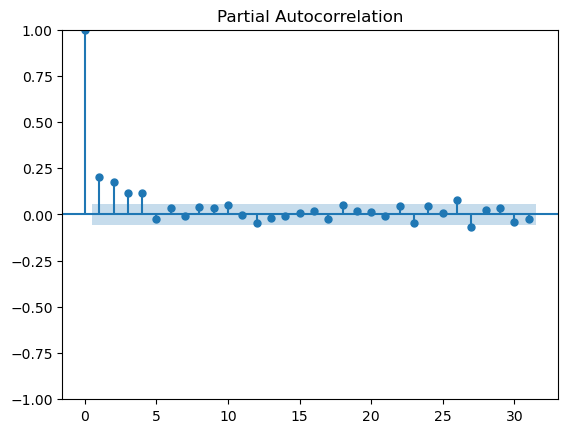

In [377]:
plot_pacf(garch_train**2)
plt.show()

In [401]:
garch_model = arch_model(garch_train[:4], p=1, q=1, rescale=False).fit(disp='off')
pred_single = garch_model.forecast(horizon=5)
print(pred_single.variance.values[-1,:])
pred_single.variance.values

[0.00011094 0.00011755 0.00012416 0.00013076 0.00013737]


array([[0.00011094, 0.00011755, 0.00012416, 0.00013076, 0.00013737]])

In [399]:
garch_train[:5]

0    0.008819
1    0.008901
2    0.000791
3   -0.013210
4    0.010281
Name: SP_ajclose, dtype: float64

In [398]:
garch_total_ret[:-test_size+3]

[0.00881948387262217,
 0.008901002493194768,
 0.0007908686573366931,
 -0.013210238443056526]

In [392]:
pred_garch_test

[0.0,
 4.075931028629879e-05,
 0.003812737026307246,
 0.010532928991620432,
 0.01024272279285509,
 0.009273088366124763,
 0.010702328859180155,
 0.009273527450411299,
 0.008330979203909057,
 0.008057256795962503,
 0.007682803005615774,
 0.005981470846601475,
 0.005350436654613201,
 0.007015009100417077,
 0.005305139789023712,
 0.00685318170978071,
 0.0069400383202581776,
 0.006752615019258106,
 0.006561369011227412,
 0.00651543562080446,
 0.0064084725252398535,
 0.006366703211800569,
 0.006451644109181158,
 0.006448708371419227,
 0.0063294732552546164,
 0.006334442565230703,
 0.0062014481187753845,
 0.006495506199817001,
 0.006400637861554099,
 0.006273186130673821,
 0.006152634347520514,
 0.006045169095384727,
 0.006237686774111105,
 0.006198749689456255,
 0.0061292540609703345,
 0.006162853119983982,
 0.0062700034361544855,
 0.006164248820946421,
 0.006074026987247982,
 0.006045992133117251,
 0.005979509133082426,
 0.00588964617381724,
 0.00580506520486564,
 0.00572461491919891,
 0.0

In [379]:
garch_model.summary()

c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             SP_ajclose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4183.33
Distribution:                  Normal   AIC:                          -8358.66
Method:            Maximum Likelihood   BIC:                          -8338.24
                                        No. Observations:                 1217
Date:                Thu, Nov 30 2023   Df Residuals:                     1216
Time:                        16:14:01   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.1103e-04  4.394e-05     18.456  4.641e-76 [7.249e-04,8.972e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.8254e-06  9.106e-12  7.496e+05      0.000 [6.825e-06,6.825e-06]
alpha[1]       0.2000  4.167e-02      4.799  1.596e-06     [  0.118,  0.282]
beta[1]        0.7000  3.448e-02     20.302  1.237e-91     [  0.632,  0.768]
============================================================================

Covariance estimator: robust
"""

In [380]:
garch_total_ret = garch_train.tolist() + garch_test.tolist()
pred_garch_test = []
test_size = len(garch_total_ret) - 1
# test_size = len(garch_test)
for i in range(test_size):
    train = garch_total_ret[:-test_size+i]
    model = arch_model(train, p=1, q=1, rescale=False).fit(disp='off')
    pred_single = model.forecast(horizon=1)
    pred_garch_test.append(np.sqrt(pred_single.variance.values[-1,:][0]))


c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\volatility.py:1196: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\yuril\anaconda3\lib\site-packages\arch\univariate\distribution.py:451: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users

MSE:  1.7960746589528746e-05
RMSE:  0.004238012103513715


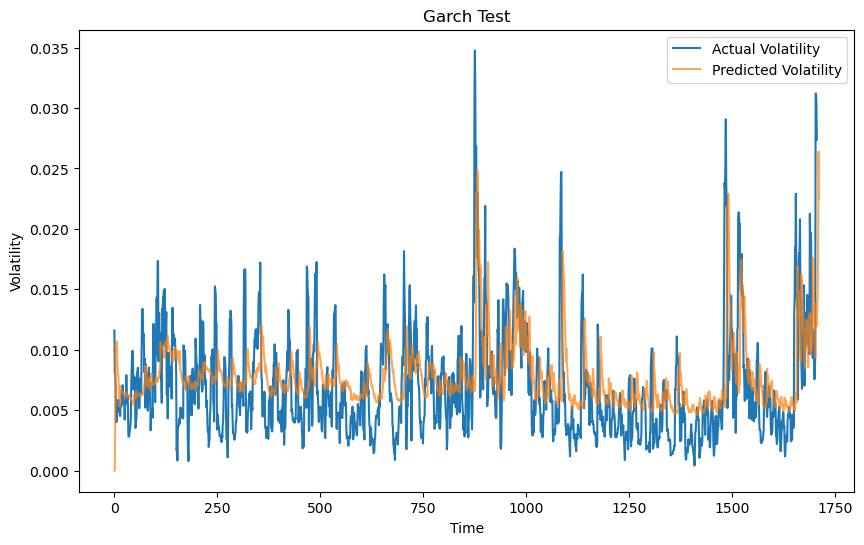

In [404]:
print("MSE: ", mean_squared_error(garch_real_vol[6:], pred_garch_test[:-5]))
print("RMSE: ", mean_squared_error(garch_real_vol[6:], pred_garch_test[:-5]) ** 0.5)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(garch_real_vol[6:], label='Actual Volatility')
plt.plot(pred_garch_test, label='Predicted Volatility', alpha=0.7)
plt.title('Garch Test')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# LSTM

In [440]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Forward propagate LSTM
        output, _ = self.lstm(x)  # LSTM outputs also hidden states, but we are ignoring them
        # Decode the hidden state of the last time step
        output = self.fc(output[:, -1, :])
        return output


In [441]:
input_size = train_loader.dataset[0][0].shape[1].__int__()
input_size

15

In [445]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# Instantiate the model
model_lstm = LSTMModel(input_size=input_size, hidden_size=6, n_layers=1, output_size=1).to(device)

torch.seed = 42
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

epochs = 100
patience = 14
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    running_loss = 0.0
    model_lstm.train()  # Set the model to training mode

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model_lstm(inputs)  # Forward pass
        outputs = outputs.squeeze()  # Remove the dimension of 1
        #print("outputs:", outputs)
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()

    # Validation loss for early stopping
    model_lstm.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = sum(loss_fn(model_lstm(X).squeeze(), y).item() for X, y in test_loader)
        #for inputs, labels in test_loader:
        #    outputs = model_uni_gru(inputs)
        #    outputs = outputs.squeeze()
        #    print("outputs:", outputs)
        #   val_loss = loss_fn(outputs, labels)

    # Early stopping logic
    # if val_loss < best_loss:
    #     best_loss = val_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience and epoch > 20:
    #         print("Early stopping triggered")
    #         break

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(test_loader)}")

Epoch 1, Loss: 0.021240734958555548, Val Loss: 0.0022310167177541492
Epoch 2, Loss: 0.0017728903924580663, Val Loss: 0.0010813311295351014
Epoch 3, Loss: 0.0013058060135032671, Val Loss: 0.0007847176716798761
Epoch 4, Loss: 0.000976858022622764, Val Loss: 0.0005888203833213386
Epoch 5, Loss: 0.0007393527702758244, Val Loss: 0.00045142352610128
Epoch 6, Loss: 0.0005638031697890256, Val Loss: 0.00035152999589627143
Epoch 7, Loss: 0.0004306896048122629, Val Loss: 0.0002770502383403558
Epoch 8, Loss: 0.00032769249427171116, Val Loss: 0.00022072806114010747
Epoch 9, Loss: 0.0002471025533911112, Val Loss: 0.00017805444537467944
Epoch 10, Loss: 0.0001841731981767225, Val Loss: 0.00014608130210641928
Epoch 11, Loss: 0.000135970656350158, Val Loss: 0.00012266624538218214
Epoch 12, Loss: 0.00010043319292890373, Val Loss: 0.0001059754617017461
Epoch 13, Loss: 7.560025559238663e-05, Val Loss: 9.42359933408928e-05
Epoch 14, Loss: 5.9206278644220824e-05, Val Loss: 8.579267388692339e-05
Epoch 15, Los

MSE:  1.8474626e-05
RMSE:  0.00429821194262961


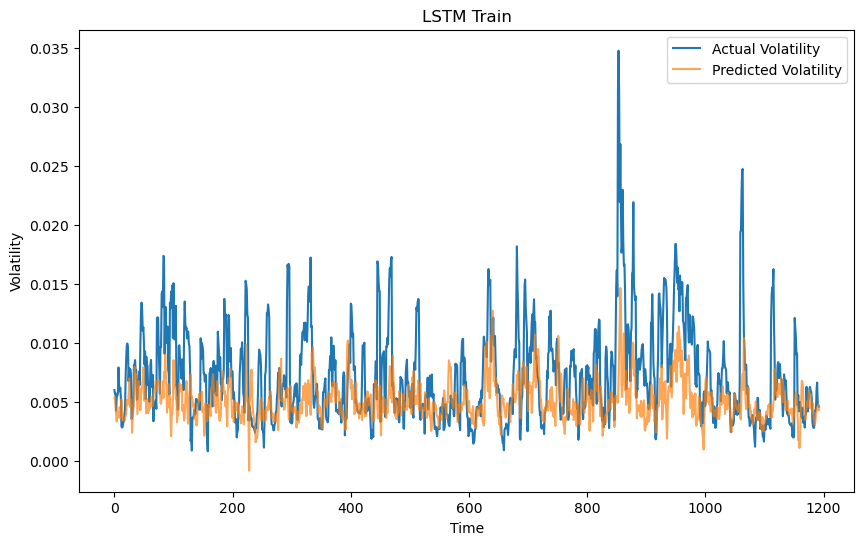

In [446]:
model_lstm.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for X, y in train_loader:
        # Get the model output
        output = model_lstm(X).squeeze()

        # Store predictions and actual values
        predictions.extend(output.numpy())
        actuals.extend(y.numpy())

print("MSE: ", mean_squared_error(actuals, predictions))
print("RMSE: ", mean_squared_error(actuals, predictions) ** 0.5)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Volatility')
plt.plot(predictions, label='Predicted Volatility', alpha=0.7)
plt.title('LSTM Train')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

MSE:  2.7056863e-05
RMSE:  0.005201621235082639


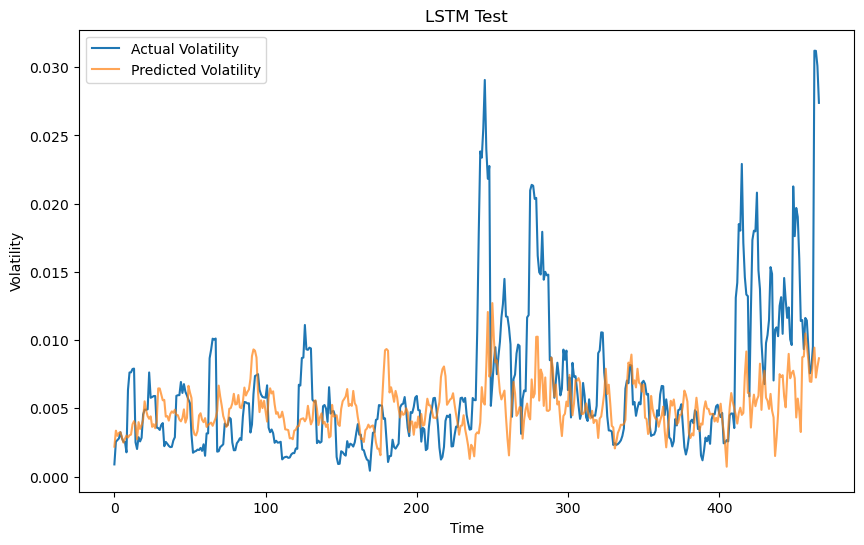

In [447]:
model_lstm.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for X, y in test_loader:
        # Get the model output
        output = model_lstm(X).squeeze()

        # Store predictions and actual values
        predictions.extend(output.numpy())
        actuals.extend(y.numpy())

print("MSE: ", mean_squared_error(actuals, predictions))
print("RMSE: ", mean_squared_error(actuals, predictions) ** 0.5)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Volatility')
plt.plot(predictions, label='Predicted Volatility', alpha=0.7)
plt.title('LSTM Test')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Transformer
from keras.layers import Dense, LSTM, Dropout



In [128]:
sequence_length = 24
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [129]:
model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64)
 
# 评估模型性能
loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {loss}')
 
# 预测未来的波动率
forecast = model.predict(X_test)

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

# Transformer

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, channels):

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * channels,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)


# NN data

In [421]:
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length), :])
        ys.append(y.iloc[i + sequence_length])

    return np.array(Xs), np.array(ys)


In [422]:
y_train

0       0.009794
1       0.011617
2       0.011606
3       0.008071
4       0.008048
          ...   
1212    0.006035
1213    0.006618
1214    0.004785
1215    0.004689
1216    0.004573
Name: SP_ajclose_vol5_t+5, Length: 1217, dtype: float64

In [423]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [435]:
lgbm_estimator = LGBMRegressor()
rfe = RFE(lgbm_estimator, n_features_to_select=15, step=1)
rfe.fit(X_train, y_train)
X_train_selected = X_train[:, rfe.support_]
X_test_selected = X_test[:, rfe.support_]

X_train_selected.shape, X_test_selected.shape

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36548
[LightGBM] [Info] Number of data points in the train set: 1217, number of used features: 144
[LightGBM] [Info] Start training from score 0.007287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36293
[LightGBM] [Info] Number of data points in the train set: 1217, number of used features: 143
[LightGBM] [Info] Start training from score 0.007287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36038
[LightGBM] [Info] Number of data points in the train set: 1217, number of used features: 142
[LightGBM] [Info] Start 

((1217, 15), (491, 15))

In [436]:
sequence_length = 24

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test, sequence_length)

# X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
# X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((1193, 24, 15), (1193,), (467, 24, 15), (467,))

In [426]:
y_test_seq[0:16]

array([0.00088878, 0.00254888, 0.00267304, 0.00279255, 0.00325003,
       0.00280125, 0.00254479, 0.00254498, 0.0017747 , 0.00635983,
       0.0076255 , 0.00763658, 0.00788111, 0.00791148, 0.00250208,
       0.00201573])

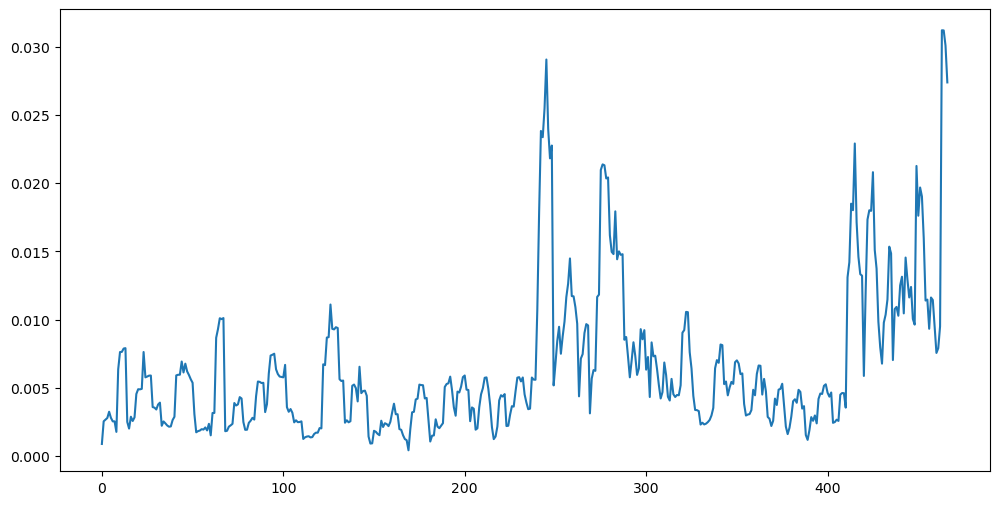

In [437]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq)
plt.show()


In [438]:
X_train_tensor = torch.tensor(X_train_seq).float()
y_train_tensor = torch.tensor(y_train_seq).float()
X_test_tensor = torch.tensor(X_test_seq).float()
y_test_tensor = torch.tensor(y_test_seq).float()

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([1193, 24, 15]),
 torch.Size([1193]),
 torch.Size([467, 24, 15]),
 torch.Size([467]))

In [439]:
batch_size = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader.dataset[0][0].shape

torch.Size([24, 15])

In [261]:
for _, y in test_loader:
    print(y[0].item())
    break

0.003761511528864503


# GRU

In [192]:
class UniGRUModel(nn.Module):
    def __init__(self, input_size):
        super(UniGRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=64, batch_first=True)
        self.gru2 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        self.gru3 = nn.GRU(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        #print("Input size:", x.shape)
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        # Select the output of the last time step
        #print("after 3rd lstm:", x.shape)
        x = x[:, -1, :]
        x = self.fc(x)
        #print("after fc:", x.shape)
        return x

In [193]:
input_size = train_loader.dataset[0][0].shape[1].__int__()
input_size

144

In [194]:
model_uni_gru = UniGRUModel(input_size=input_size)

torch.seed = 42
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_uni_gru.parameters(), lr=0.001)

epochs = 100
patience = 14
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    running_loss = 0.0
    model_uni_gru.train()  # Set the model to training mode

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model_uni_gru(inputs)  # Forward pass
        outputs = outputs.squeeze()  # Remove the dimension of 1
        #print("outputs:", outputs)
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()

    # Validation loss for early stopping
    model_uni_gru.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = sum(loss_fn(model_uni_gru(X).squeeze(), y).item() for X, y in test_loader)
        #for inputs, labels in test_loader:
        #    outputs = model_uni_gru(inputs)
        #    outputs = outputs.squeeze()
        #    print("outputs:", outputs)
        #   val_loss = loss_fn(outputs, labels)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience and epoch > 20:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(test_loader)}")

Epoch 1, Loss: 0.0008437832591274249, Val Loss: 0.0001070048290178723
Epoch 2, Loss: 4.695377207099227e-05, Val Loss: 6.061797691169583e-05
Epoch 3, Loss: 2.4945312849619463e-05, Val Loss: 4.607007805740674e-05
Epoch 4, Loss: 1.907042033659915e-05, Val Loss: 4.439524884674029e-05
Epoch 5, Loss: 1.6953538802226832e-05, Val Loss: 4.3873390670038743e-05
Epoch 6, Loss: 1.5072445903570041e-05, Val Loss: 4.207497784894561e-05
Epoch 7, Loss: 1.3486446368915494e-05, Val Loss: 4.006082183802088e-05
Epoch 8, Loss: 1.2256840176026647e-05, Val Loss: 3.80382349400558e-05
Epoch 9, Loss: 1.127640146023623e-05, Val Loss: 3.607575305674497e-05
Epoch 10, Loss: 1.0472160474819248e-05, Val Loss: 3.426002137227139e-05
Epoch 11, Loss: 9.797564396952415e-06, Val Loss: 3.265320852771462e-05
Epoch 12, Loss: 9.220800341912157e-06, Val Loss: 3.126528645225335e-05
Epoch 13, Loss: 8.720840805835905e-06, Val Loss: 3.0076220226267955e-05
Epoch 14, Loss: 8.2855437813123e-06, Val Loss: 2.9063251959845125e-05
Epoch 15,

MSE:  8.154327e-06
RMSE:  0.0028555781689138856


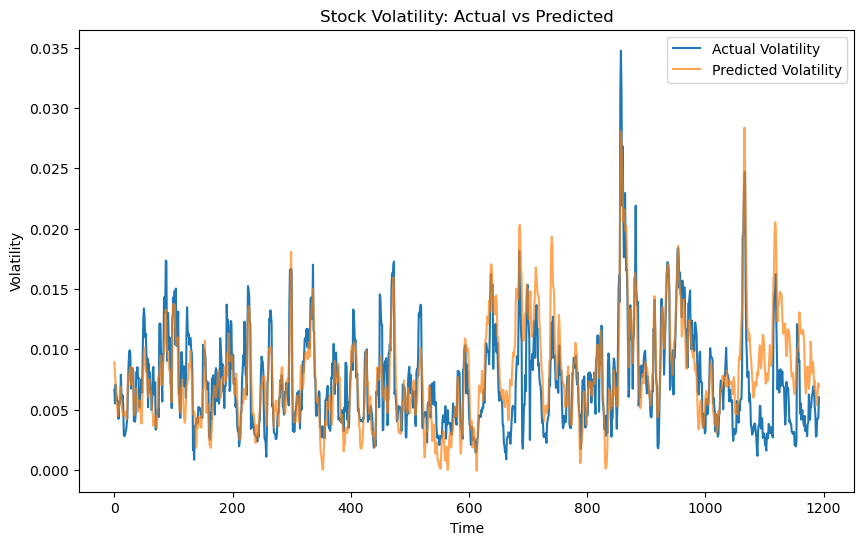

In [195]:
model_uni_gru.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for X, y in train_loader:
        # Get the model output
        output = model_uni_gru(X).squeeze()

        # Store predictions and actual values
        predictions.extend(output.numpy())
        actuals.extend(y.numpy())

print("MSE: ", mean_squared_error(actuals, predictions))
print("RMSE: ", mean_squared_error(actuals, predictions) ** 0.5)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Volatility')
plt.plot(predictions, label='Predicted Volatility', alpha=0.7)
plt.title('Stock Volatility: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

MSE:  1.8868162e-05
RMSE:  0.0043437498134942755


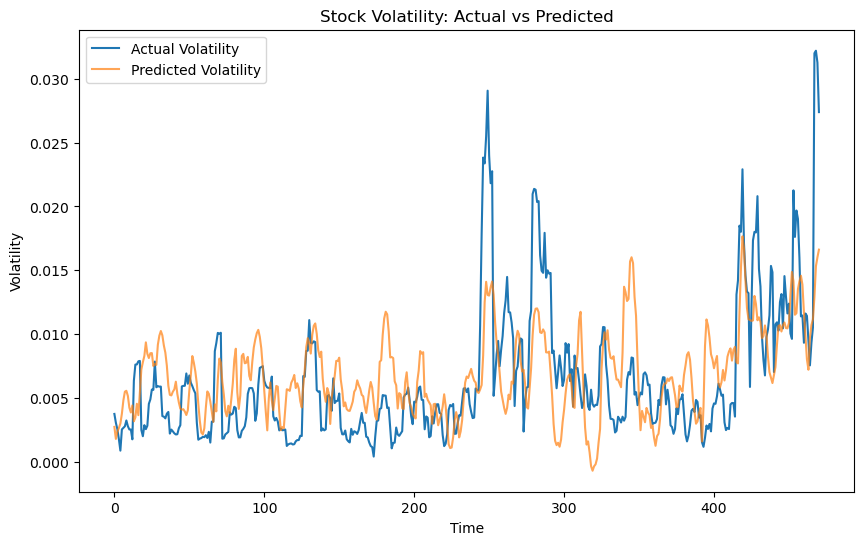

In [197]:
model_uni_gru.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for X, y in test_loader:
        # Get the model output
        output = model_uni_gru(X).squeeze()

        # Store predictions and actual values
        predictions.extend(output.numpy())
        actuals.extend(y.numpy())

print("MSE: ", mean_squared_error(actuals, predictions))
print("RMSE: ", mean_squared_error(actuals, predictions) ** 0.5)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Volatility')
plt.plot(predictions, label='Predicted Volatility', alpha=0.7)
plt.title('Stock Volatility: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [93]:
mean_squared_error(actuals, predictions)

2.7725378e-05

In [38]:
df = pd.read_csv(PATH + 'FINAL_USO.csv')

In [39]:
df['SP_Vol'] = np.log(df['SP_close'] / df['SP_close'].shift(1)).rolling(window=14).std().shift(-14)
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume,SP_Vol
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700,0.011162
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800,0.010928
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200,0.010160
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600,0.007279
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000,0.007275
5,2011-12-22,156.350006,156.800003,155.330002,156.039993,156.039993,9888400,124.629997,125.400002,124.230003,...,52.400002,49.656178,13179600,38.270000,38.549999,38.209999,38.279999,38.279999,5376800,0.007377
6,2011-12-23,156.350006,156.490005,155.820007,156.309998,156.309998,3565100,125.669998,126.430000,125.410004,...,52.790001,50.169365,4729000,38.470001,38.610001,38.369999,38.490002,38.490002,2162200,0.007134
7,2011-12-27,155.080002,155.550003,154.539993,154.910004,154.910004,4918600,126.169998,126.820000,126.059998,...,51.869999,49.295036,4786400,38.490002,39.209999,38.459999,39.060001,39.060001,7834100,0.007549
8,2011-12-28,154.050003,154.259995,150.660004,151.029999,151.029999,16436100,126.510002,126.529999,124.730003,...,50.060001,47.574883,14170400,38.880001,38.889999,38.189999,38.340000,38.340000,5654300,0.006088
9,2011-12-29,149.089996,150.720001,148.270004,150.339996,150.339996,19812200,125.239998,126.250000,124.860001,...,51.200001,48.658298,12196600,38.389999,38.459999,37.869999,38.410000,38.410000,8924300,0.005787


In [40]:
# select features
df.head().style.background_gradient(cmap='Reds')

AttributeError: 'ColormapRegistry' object has no attribute 'get_cmap'

In [41]:
df.isnull().sum()

Date              0
Open              0
High              0
Low               0
Close             0
                 ..
USO_Low           0
USO_Close         0
USO_Adj Close     0
USO_Volume        0
SP_Vol           14
Length: 82, dtype: int64

In [42]:
df.dropna(inplace=True)

In [43]:
df.isnull().sum()

Date             0
Open             0
High             0
Low              0
Close            0
                ..
USO_Low          0
USO_Close        0
USO_Adj Close    0
USO_Volume       0
SP_Vol           0
Length: 82, dtype: int64

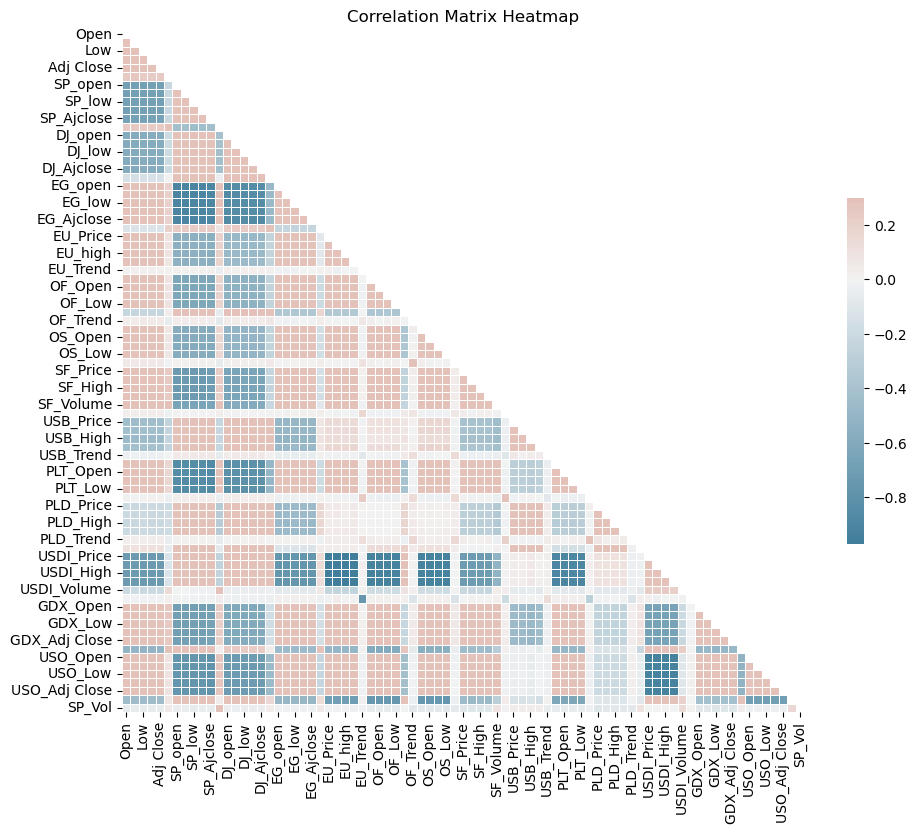

In [45]:
correlation_matrix = df.drop(['Date'],axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure with more modern aesthetics
plt.figure(figsize=(11, 9))

# Create a colormap for better visual appeal
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=0.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

# Add titles and labels as necessary
plt.title('Correlation Matrix Heatmap')
plt.show()

In [46]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)

In [47]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume,SP_Vol
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700,0.011162
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800,0.010928
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200,0.010160
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600,0.007279
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000,0.007275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2018-12-03,116.599998,116.769997,116.300003,116.410004,116.410004,8469500,280.279999,280.399994,277.510010,...,19.440001,19.337685,47882800,11.270000,11.270000,11.020000,11.270000,11.270000,32582300,0.012793
1700,2018-12-04,117.370003,117.389999,116.930000,117.120003,117.120003,7186100,278.369995,278.850006,269.899994,...,19.600000,19.496843,45434300,11.250000,11.350000,11.150000,11.180000,11.180000,27194400,0.019711
1701,2018-12-06,117.379997,117.690002,116.919998,117.139999,117.139999,9267600,265.920013,269.970001,262.440002,...,19.709999,19.606262,50911100,10.860000,11.000000,10.600000,10.940000,10.940000,45909400,0.020044
1702,2018-12-07,117.620003,118.230003,117.540001,118.089996,118.089996,10402900,269.459991,271.220001,262.630005,...,20.200001,20.093685,67727400,11.370000,11.480000,11.080000,11.110000,11.110000,43287600,0.019422


In [48]:
X = df.drop(['Date', 'SP_Vol'], axis=1)
y = df['SP_Vol']

X.shape, y.shape

((1704, 80), (1704,))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1363, 80), (341, 80), (1363,), (341,))

In [50]:
scalar = MinMaxScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

c:\Users\yuril\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\yuril\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\yuril\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [51]:
lgbm_estimator = LGBMRegressor()
rfe = RFE(lgbm_estimator, n_features_to_select=15, step=1)
rfe.fit(X_train_scaled, y_train)
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

X_train_selected.shape, X_test_selected.shape

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18228
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 80
[LightGBM] [Info] Start training from score 0.007377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17973
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 79
[LightGBM] [Info] Start training from score 0.007377
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17718
[LightGBM] [Info] Number of data points in the train set: 1363, number of used features: 78
[LightGBM] [Info] Start tra

((1363, 15), (341, 15))

In [52]:
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length), :])
        ys.append(y.iloc[i + sequence_length])
    return np.array(Xs), np.array(ys)


In [54]:
type(X_test_selected)

numpy.ndarray

In [55]:
type(y_test)

pandas.core.series.Series

In [53]:
X_test_selected[0:24, :].shape

(24, 15)

In [17]:
y_test

1363    0.006531
1364    0.006532
1365    0.006552
1366    0.007206
1367    0.007244
          ...   
1699    0.012793
1700    0.019711
1701    0.020044
1702    0.019422
1703    0.019677
Name: SP_Vol, Length: 341, dtype: float64

In [42]:
sequence_length = 24

X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test, sequence_length)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((1339, 24, 15), (1339,), (317, 24, 15), (317,))

In [51]:
y_test_seq[0:16]

array([0.00404628, 0.00403927, 0.00348282, 0.00340277, 0.00350204,
       0.00345017, 0.00225814, 0.00266784, 0.00266803, 0.00296124,
       0.00271016, 0.00282549, 0.00285028, 0.00283735, 0.00272083,
       0.00269729])

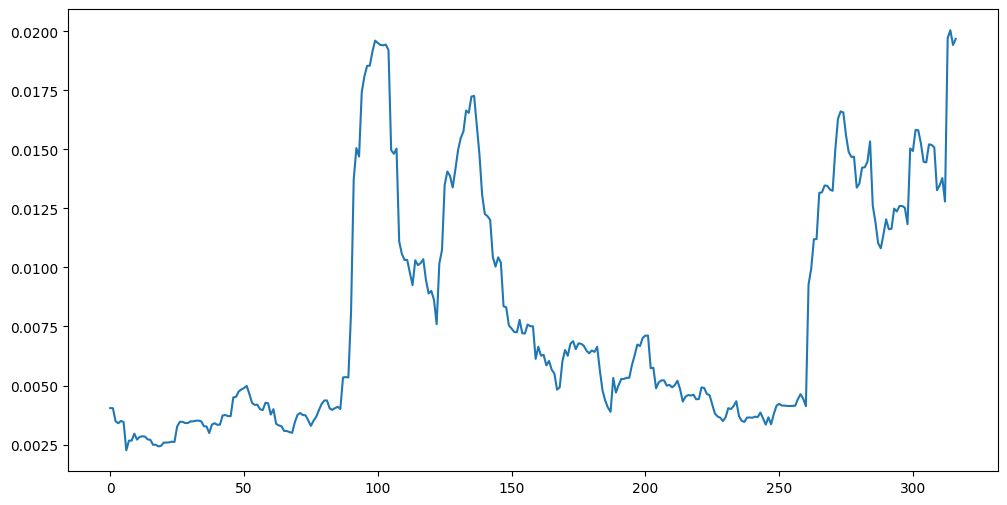

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq)
plt.show()


In [62]:
X_train_tensor = torch.tensor(X_train_seq).float()
y_train_tensor = torch.tensor(y_train_seq).float()
X_test_tensor = torch.tensor(X_test_seq).float()
y_test_tensor = torch.tensor(y_test_seq).float()

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([1339, 24, 15]),
 torch.Size([1339]),
 torch.Size([317, 24, 15]),
 torch.Size([317]))

In [63]:
batch_size = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader.dataset[0][0].shape

torch.Size([24, 15])

In [65]:
for _, y in test_loader:
    print(y[0].item())
    break

0.004046278540045023


In [66]:
class UniGRUModel(nn.Module):
    def __init__(self, input_size):
        super(UniGRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=64, batch_first=True)
        self.gru2 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        self.gru3 = nn.GRU(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        #print("Input size:", x.shape)
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        # Select the output of the last time step
        #print("after 3rd lstm:", x.shape)
        x = x[:, -1, :]
        x = self.fc(x)
        #print("after fc:", x.shape)
        return x

In [67]:
input_size = train_loader.dataset[0][0].shape[1].__int__()
input_size

15

In [74]:
model_uni_gru = UniGRUModel(input_size=input_size)

torch.seed = 42
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_uni_gru.parameters(), lr=0.001)

epochs = 100
patience = 14
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    running_loss = 0.0
    model_uni_gru.train()  # Set the model to training mode

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model_uni_gru(inputs)  # Forward pass
        outputs = outputs.squeeze()  # Remove the dimension of 1
        #print("outputs:", outputs)
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()

    # Validation loss for early stopping
    model_uni_gru.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = sum(loss_fn(model_uni_gru(X).squeeze(), y).item() for X, y in test_loader)
        #for inputs, labels in test_loader:
        #    outputs = model_uni_gru(inputs)
        #    outputs = outputs.squeeze()
        #    print("outputs:", outputs)
        #   val_loss = loss_fn(outputs, labels)

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience and epoch > 20:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(test_loader)}")

Epoch 1, Loss: 0.0004862299289371885, Val Loss: 0.000226431798955673
Epoch 2, Loss: 0.00015626223038468976, Val Loss: 7.082152192197099e-05
Epoch 3, Loss: 0.00016452483146370663, Val Loss: 5.3605566870373876e-05
Epoch 4, Loss: 0.00012860438384722426, Val Loss: 9.695214121734353e-05
Epoch 5, Loss: 0.00010439716111168959, Val Loss: 0.00012183662457800892
Epoch 6, Loss: 8.347844233875483e-05, Val Loss: 0.0002992133884731629
Epoch 7, Loss: 5.810050766778355e-05, Val Loss: 0.0003254352391252269
Epoch 8, Loss: 8.269024859381651e-05, Val Loss: 0.0001616297656852339
Epoch 9, Loss: 6.076964055219085e-05, Val Loss: 0.0006958222747925902
Epoch 10, Loss: 6.674704664668578e-05, Val Loss: 0.0002474663205703109
Epoch 11, Loss: 7.228642576522015e-05, Val Loss: 0.00035173047123180365
Epoch 12, Loss: 5.81755402809644e-05, Val Loss: 0.0003142498763054391
Epoch 13, Loss: 8.854077055565042e-05, Val Loss: 6.413028928022868e-05
Epoch 14, Loss: 7.613487513544843e-05, Val Loss: 0.0001301049833386969
Epoch 15, 

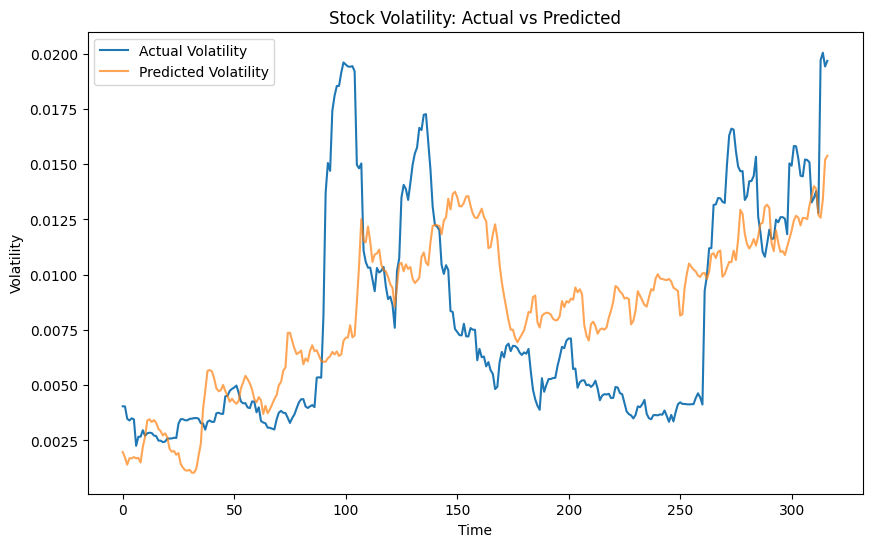

In [75]:
model_uni_gru.eval()  # Set the model to evaluation mode

actuals = []
predictions = []

with torch.no_grad():
    for X, y in test_loader:
        # Get the model output
        output = model_uni_gru(X).squeeze()

        # Store predictions and actual values
        predictions.extend(output.numpy())
        actuals.extend(y.numpy())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Volatility')
plt.plot(predictions, label='Predicted Volatility', alpha=0.7)
plt.title('Stock Volatility: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()